In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Data Collection: 

In [3]:
import pandas as pd

# Load dataset
data = pd.read_csv("/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv", sep="\t")


In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
print(data.columns)

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')


In [6]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [8]:
# Let's drop this record
data.dropna(inplace=True)

In [9]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [10]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [11]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [12]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: I sent it to my 85 year old Dad, and he talks to it constantly.
Length of review : 63
'length' column value : 63


We can see that the length of review is the same as the value in the length column for that record, Hence Verified

In [13]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating, feedback and length are integer values
  
* date, variation and verified_reviews are string values

# **2. Data Preprocessing:**

**2.1 Analyzing Rating Column**

In [14]:
len(data)

3149

In [15]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


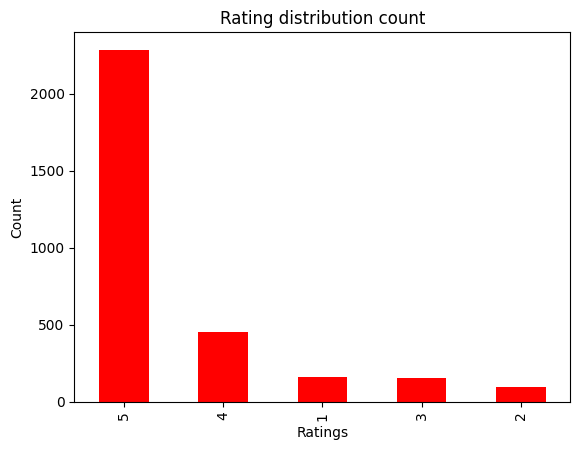

In [16]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [17]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


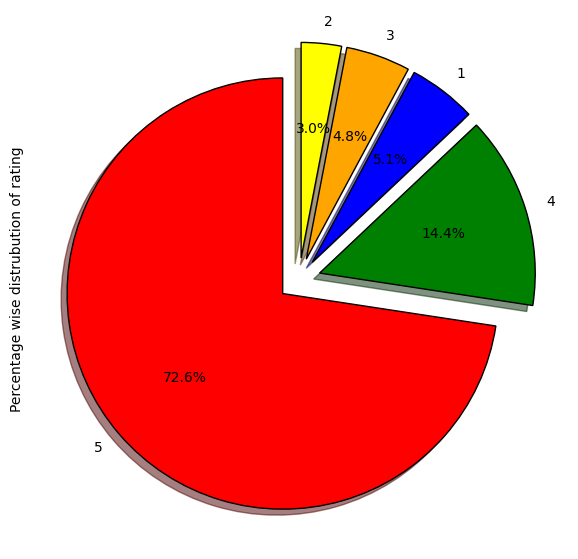

In [18]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

**2.2 Analyzing 'feedback' column**

In [19]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [20]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [21]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


**Conclusion of feedback column**

From the above 2 examples we can see that feedback **0 is negative** review and **1 is positive review**

Let's plot the feedback value count in a bar graph

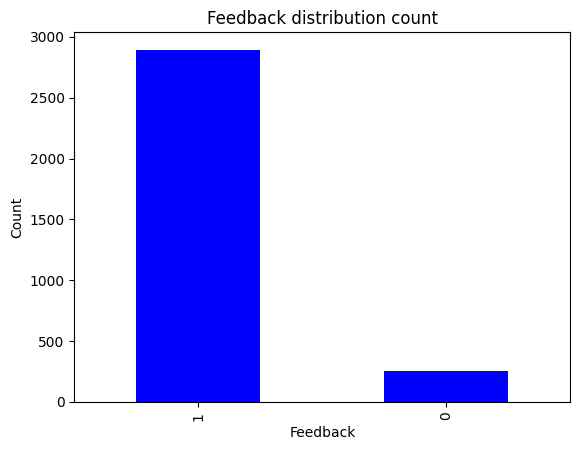

In [22]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [23]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


**Feedback distribution**

* 91.87% reviews are positive
  
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

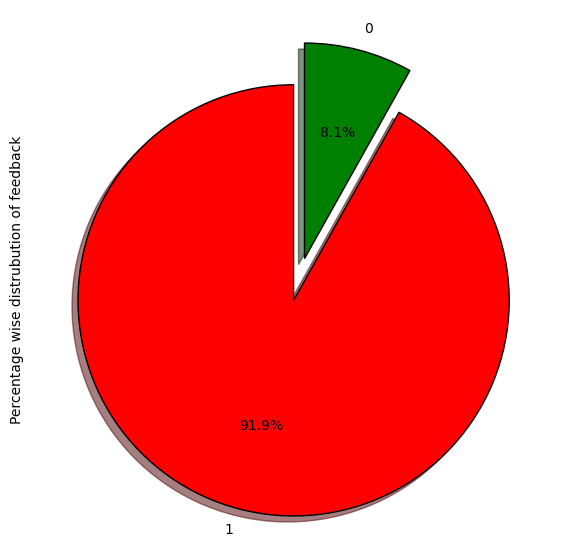

In [24]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [25]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [26]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

If rating of a review is **1 or 2 then the feedback is 0 (negative)** and if the rating is **3, 4 or 5 then the feedback is 1 (positive).**

**2.3 Analyzing 'variation' column**

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [27]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


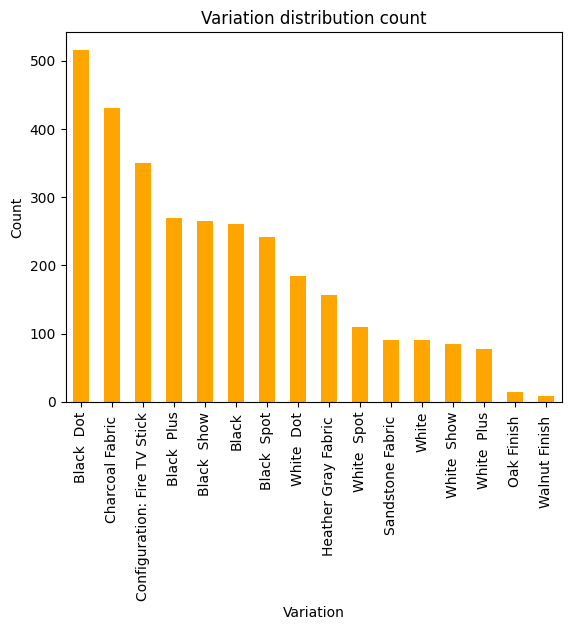

In [28]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [29]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [30]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

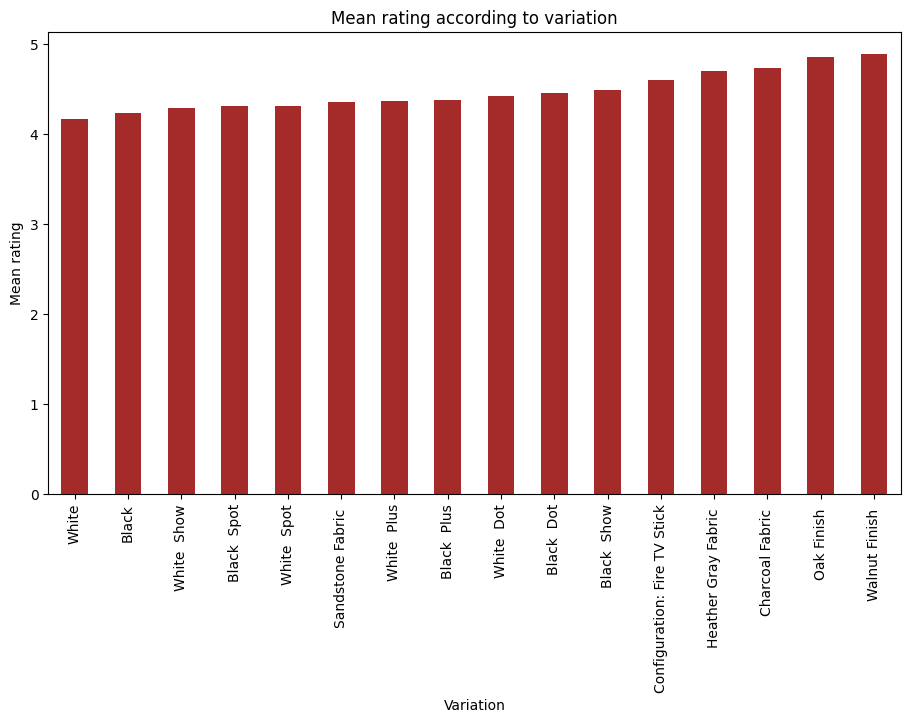

In [31]:
# Let's analyze the above ratings
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

**2.4 Analyzing 'verified_reviews' column**

This column contains the textual review given by the user for a variation for the product.

In [32]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review ')]

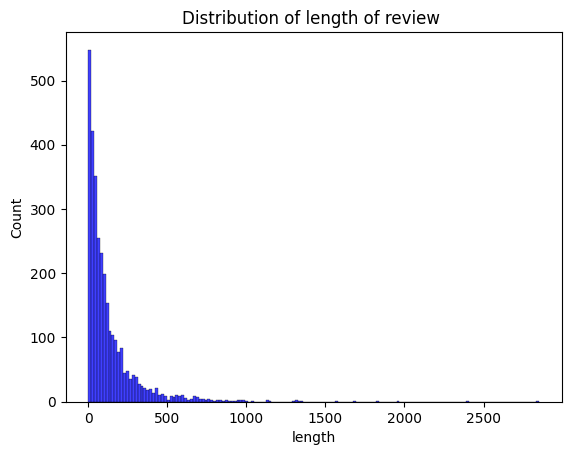

In [33]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

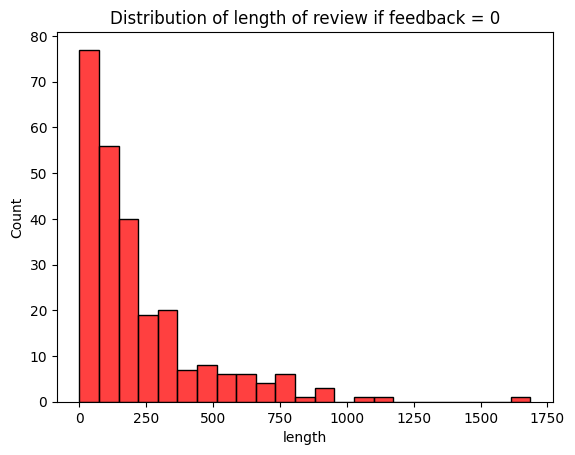

In [34]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

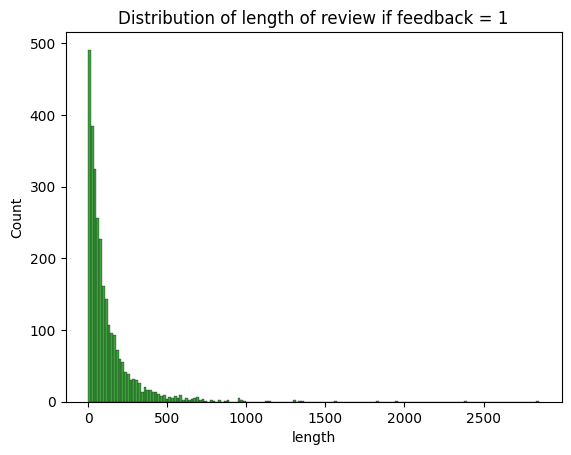

In [35]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

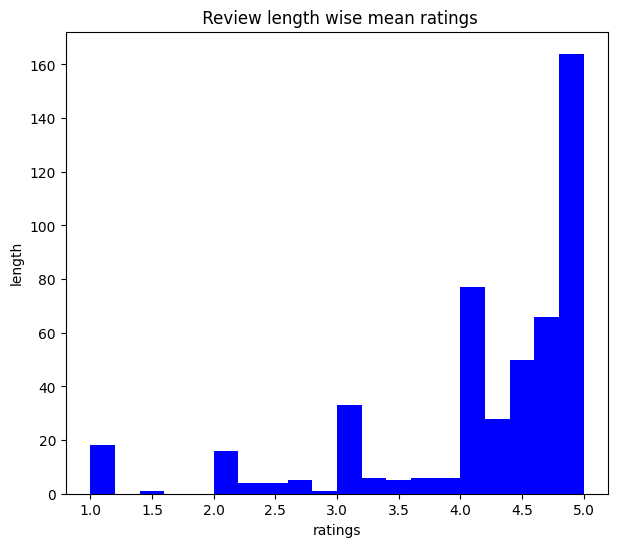

In [36]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [37]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

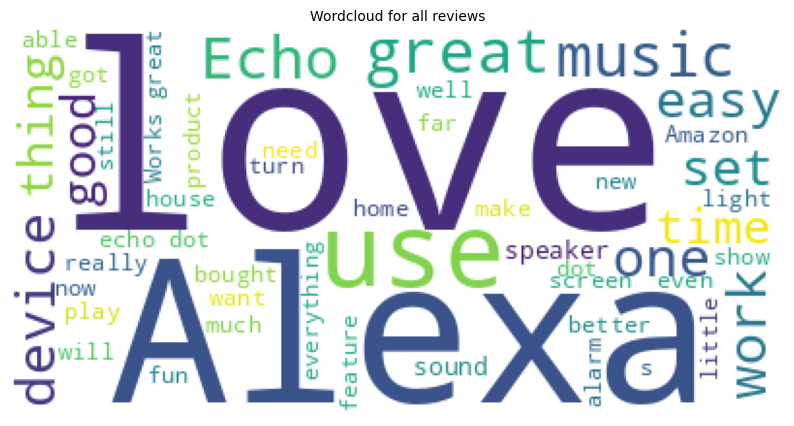

In [38]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [39]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

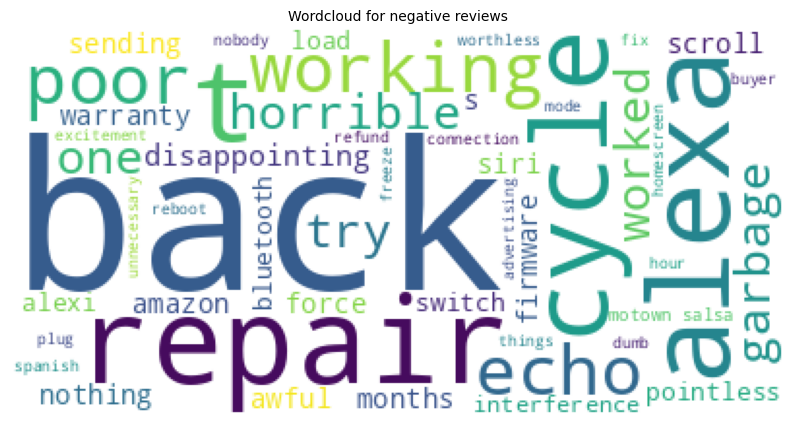

In [40]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

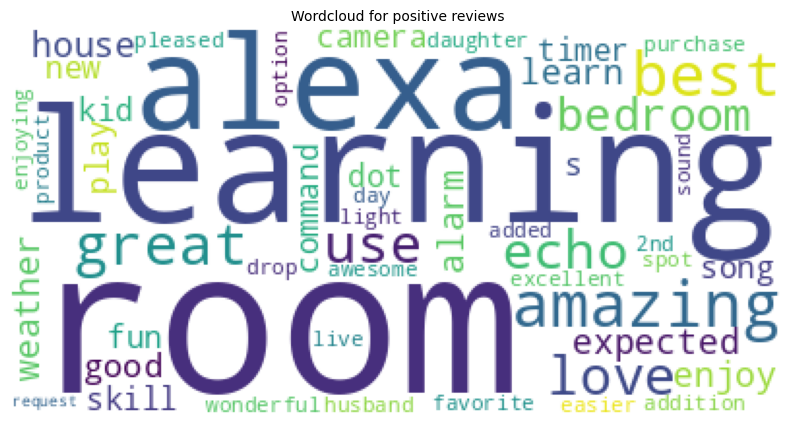

In [41]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# **Preprocessing and Modelling**

To build the corpus from the 'verified_reviews' we perform the following -

1. Replace any non alphabet characters with a space

2. Covert to lower case and split into words

3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [42]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [43]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [44]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2519, 2500)
y train: (2519,)
X test: (630, 2500)
y test: (630,)


In [46]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 7


We'll scale X_train and X_test so that all values are between 0 and 1.

In [47]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

# **Random Forest**

In [48]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [49]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9952362048431918
Testing Accuracy : 0.9380952380952381


In [50]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

# **Logistic Regression**

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)


LogisticRegression()

In [52]:
# Predict on test data
y_pred = model.predict(X_test)

In [53]:
# Check accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.93


# Naive Bayes 


In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Initialize the model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)


MultinomialNB()

In [55]:
# Predict on test data
y_pred_nb = nb_model.predict(X_test)


In [56]:
# Evaluate
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naïve Bayes Accuracy: {accuracy_nb:.2f}")

Naïve Bayes Accuracy: 0.93


# Support Vector Machine 

In [57]:
from sklearn.svm import SVC

# Initialize the model
svm_model = SVC()

# Train the model
svm_model.fit(X_train, y_train)

SVC()

In [58]:
# Predict on test data
y_pred_svm = svm_model.predict(X_test)

In [59]:
# Evaluate
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")

SVM Accuracy: 0.92


# 3. Feature Extraction: using TF-IDF

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features

# Transform text data
X_tfidf = tfidf.fit_transform(data['verified_reviews'])

# Convert to array
X = X_tfidf.toarray()

# Extract target variable (assuming sentiment is stored in 'feedback' column)
y = data['feedback']


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features

# Transform text data
X_tfidf = tfidf.fit_transform(data['verified_reviews'])

# Converting to array
X = X_tfidf.toarray()

# Extracting target variable 
y = data['feedback']


In [71]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (2519, 4044), X_test shape: (630, 4044)


In [72]:
# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict & Evaluate
y_pred_lr = log_reg.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")


Logistic Regression Accuracy: 0.92


In [73]:
# Train Naïve Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict & Evaluate
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naïve Bayes Accuracy: {accuracy_nb:.2f}")


Naïve Bayes Accuracy: 0.92


In [74]:
# Train SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict & Evaluate
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")


SVM Accuracy: 0.93


In [75]:
print("\nModel Comparison:")
print(f"Logistic Regression: {accuracy_lr:.2f}")
print(f"Naïve Bayes: {accuracy_nb:.2f}")
print(f"SVM: {accuracy_svm:.2f}")



Model Comparison:
Logistic Regression: 0.92
Naïve Bayes: 0.92
SVM: 0.93


**Visualize Model Accuracy**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


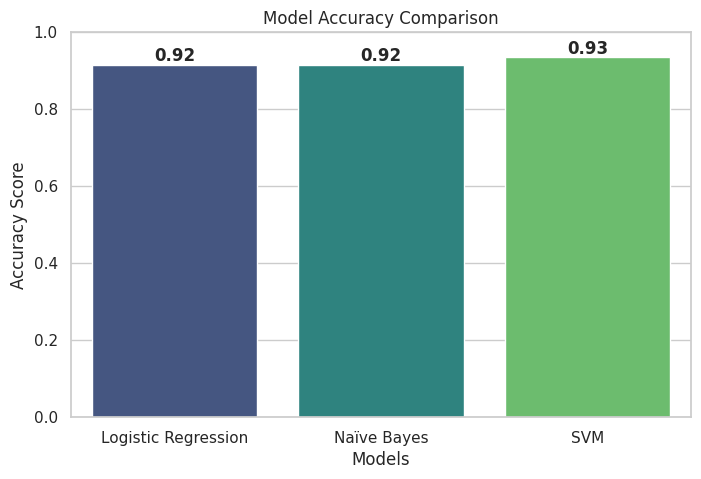

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model names and accuracies
models = ["Logistic Regression", "Naïve Bayes", "SVM"]
accuracies = [accuracy_lr, accuracy_nb, accuracy_svm]

# Set style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette="viridis")

# Add labels and title
plt.ylabel("Accuracy Score")
plt.xlabel("Models")
plt.title("Model Accuracy Comparison")

# Show accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

# Show plot
plt.ylim(0, 1)  # Ensure scale between 0 and 1
plt.show()


**Classification Report**

In [77]:
from sklearn.metrics import classification_report

# Classification Reports
print("🔹 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("\n🔹 Naïve Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("\n🔹 SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

🔹 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.92      1.00      0.96       577

    accuracy                           0.92       630
   macro avg       0.46      0.50      0.48       630
weighted avg       0.84      0.92      0.88       630


🔹 Naïve Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.92      1.00      0.96       577

    accuracy                           0.92       630
   macro avg       0.46      0.50      0.48       630
weighted avg       0.84      0.92      0.88       630


🔹 SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.23      0.37        53
           1       0.93      1.00      0.97       577

    accuracy                           0.93       630
   macro avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Hyperparameter Tuning with GridSearchCV**

In [78]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'max_iter': [100, 200, 300]
}

# Perform GridSearch for Logistic Regression
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Best Parameters & Accuracy
print(f"🔹 Best Logistic Regression Parameters: {grid_lr.best_params_}")
print(f"🔹 Best Logistic Regression Accuracy: {grid_lr.best_score_:.2f}")


🔹 Best Logistic Regression Parameters: {'C': 10, 'max_iter': 100}
🔹 Best Logistic Regression Accuracy: 0.94


**Hyperparameter Tuning for SVM**

In [79]:
# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernel types
    'gamma': ['scale', 'auto']
}

# Perform GridSearch for SVM
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Best Parameters & Accuracy
print(f"🔹 Best SVM Parameters: {grid_svm.best_params_}")
print(f"🔹 Best SVM Accuracy: {grid_svm.best_score_:.2f}")


🔹 Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
🔹 Best SVM Accuracy: 0.94
